<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/Bitcoin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Chargement des données

In [33]:
!git clone https://github.com/chentinghao/download_google_drive.git
!python download_google_drive/download_gdrive.py "1FZsEdpBm-AQ2L9n_pMnm6336-O_IVo7z" "/content/bitcoin.zip"
!unzip bitcoin.zip

fatal: destination path 'download_google_drive' already exists and is not an empty directory.
100MB [00:04, 21.5MB/s] 


In [150]:
# Création de la série sous Pandas
serie = pd.read_csv("bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv")
serie[0:100]

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
95,1325323620,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,1325323680,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,1325323740,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,1325323800,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [208]:
# Convesion des timestamp en date
serie.Timestamp = pd.to_datetime(serie['Timestamp'], unit="s")
serie

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
1,2011-12-31 07:53:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-12-31 07:54:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-12-31 07:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011-12-31 07:56:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
4857372,2021-03-30 23:56:00,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
4857373,2021-03-30 23:57:00,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
4857374,2021-03-30 23:58:00,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496
4857375,2021-03-30 23:59:00,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202


In [221]:
serie_jour = serie.set_index('Timestamp').resample('1D').asfreq()
serie_jour

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2021-03-27,55081.26,55300.00,55081.26,55261.73,8.781130,484506.899450,55175.914921
2021-03-28,55817.85,55920.82,55807.12,55920.82,0.770004,43011.953916,55859.414172
2021-03-29,55790.28,55822.98,55777.98,55804.36,1.731449,96636.546983,55812.518695


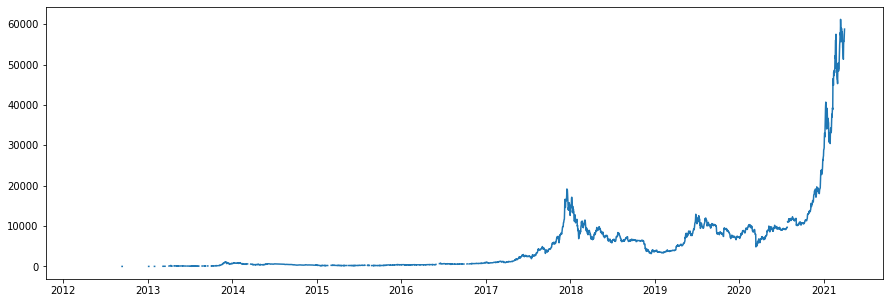

In [223]:
# Récupère les prix à l'ouverture
prix_ouverture = np.asarray(serie_jour.Open)
dates_ouverture = np.asarray(serie_jour.index)
temps_ouverture = np.asarray(serie_jour.reset_index().index.copy())

# Affiche la série
plt.figure(figsize=(15,5))
plt.plot(dates_ouverture, prix_ouverture)

# Affichage des données

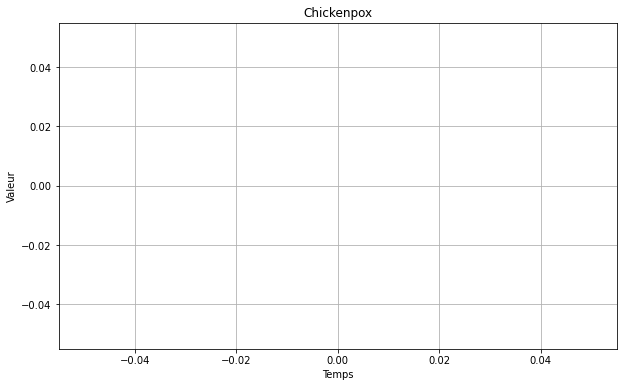

In [9]:
temps = np.linspace(0,len(serie),len(serie))
plt.figure(figsize=(10, 6))
affiche_serie(temps,serie)
plt.title('Chickenpox')
plt.show()